## 1. Загрузим данные и изучим общую информацию

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.1. Импорт библиотек pandas, numpy, datetime, matplotlib.pyplot, seaborn и других

In [2]:
import pandas as pd
from numpy import median
from datetime import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns
import math as mth
from itertools import combinations
from folium import Marker, Map, Choropleth
from folium.plugins import MarkerCluster
import json
from plotly import graph_objects as go
import plotly.express as px
import re
from scipy import stats as st
pd.set_option('display.max_columns', None) #настройка, чтобы pandas не урезал столбцы
#pd.set_option('display.max_rows', None)

### 1.2. Загрузим данные из CSV-файла

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Data/ecommerce_dataset.csv')

### 1.3. Изучим данные в датафреме data

In [4]:
display(data.head(10))
data.info();

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0
5,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0
6,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0
7,2018100108,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0
8,2018100108,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С61...",1,269.0
9,2018100109,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beig...,1,674.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


## 2. Выполним предобработку данных

### 2.1. Преобразуем данные в столбце date

In [5]:
#преобразуем дату в формат datetime
data['date'] = data['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d%H'))

### 2.2. Поиск попусков

In [6]:
data.isna().sum(); #ищем пропуски

В датафреме пропуски отсутствуют.

### 2.3. Поиск явных дубликатов

In [7]:
data.duplicated().sum() #ищем явные дубликаты

0

Явные дубликаты отсутствуют

### 2.4. Поиск неявных дубликатов

In [8]:
#определим количество неявных дубликатов без столбца с датой и изучим данные, чтобы принять решение удалять их или нет
data_dublicates = data[data.duplicated(subset=['customer_id','order_id','product','price','quantity'])]
data_dublicates.head(5)

,date,customer_id,order_id,product,quantity,price
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
63,2018-10-03 04:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
94,2018-10-04 13:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,Эвкалипт Гунни d-17 см h-60 см,1,1409.0


Получилось 1864 неявных дубликата, что составляет около 27% от исходного датафрема. Судя по всему эти заказы задвоились и их стоит удалить.

In [9]:
#удаляем неявные дубликаты
data = data.drop_duplicates(subset=['customer_id','order_id','product','price','quantity'], keep='first')
data = data.reset_index(drop=True) #выравниваем индексы

In [10]:
#выведем информацию об обновленном датафреме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4873 entries, 0 to 4872
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         4873 non-null   datetime64[ns]
 1   customer_id  4873 non-null   object        
 2   order_id     4873 non-null   int64         
 3   product      4873 non-null   object        
 4   quantity     4873 non-null   int64         
 5   price        4873 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 228.5+ KB


### 2.5. Создадим дополнительные столбцы для дальнейшего анализа: столбец с месцем и годом заказа year_month, стоблец с днем недели day_of_week и столбец с часом заказа hour

In [11]:
data['year_month'] = data['date'].dt.to_period('M')#столбец с годом и месяцем заказа
data['day_of_week'] = data['date'].dt.weekday #столбец с днем недели заказ
data['hour'] = data['date'].dt.hour #столбец с часом заказ

### 2.6. Создадим дополнительный столбец с выручкой по каждому событию revenue

In [12]:
data['revenue'] = data['price']*data['quantity']

### 2.7. Создадим столбец с названиями товара name для дальнейшего выделения категорий

In [13]:
data['name'] = data['product'] #создадим столбец с названием товара для присвоения категорий

#удалим из названия все символы, цифры и латинские буквы
data['name'].replace(regex=True,inplace=True,to_replace=r'[^А-Яа-яЁё\+]',value=r' ')

#удалим из названия слова менее двух символов и лишние пробелы
data['name'].replace(regex=True,inplace=True,to_replace=r'\b\w{1,2}\b|\s{2,}',value=r'')

data['name'] = data['name'].str.lower() #приводим все буквы к нижнему регистру
data = data.apply(lambda x:x.replace({'ё':'е'},regex=True)) #заменяем Ё на Е

In [14]:
#создадим столбец с названиями и выведем два первых слова
data['name1'] = data['name'].str.split(" ", expand=True)[0]
data['name2'] = data['name'].str.split(" ", expand=True)[1]
data['name2'] = data['name2'].fillna(' ')
data['name'] = data['name1'] + ' ' + data['name2']
data.drop(['name1','name2'], axis=1, inplace=True)

In [15]:
#выведем обновленный датафрем
data.head(5)

,date,customer_id,order_id,product,quantity,price,year_month,day_of_week,hour,revenue,name
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10,0,0,142.0,комнатное растение
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10,0,0,194.0,комнатное растение
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10,0,0,112.0,радермахера
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10,0,0,179.0,хризолидокарпус лутесценс
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10,0,0,112.0,циперус зумула


### 2.8. Проверим датафрем на аномалии

#### 2.8.1. Поиск пользователей с самым большим количеством заказов

In [16]:
#создадим датафрем orders, в котором найдем пользователей с самым большим количеством заказов
orders = (data.groupby('customer_id', as_index=False).agg({'order_id': 'nunique'}))

orders.sort_values(by='order_id', ascending=False).head(10)

,customer_id,order_id
1916,c971fb21-d54c-4134-938f-16b62ee86d3b,126
742,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35
1101,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17
1748,b7b865ab-0735-407f-8d0c-31f74d2806cc,7
17,0184f535-b60a-4914-a982-231e3f615206,5
1820,bea7a833-2074-42db-bc49-4457abd3c930,4
2147,e0535076-6270-4df2-8621-cb06264a94fa,4
699,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,4
1184,7d0641a6-e043-487d-b356-38895fe7df84,3
2307,f163e581-59ba-4022-99db-e0973c7497c0,3


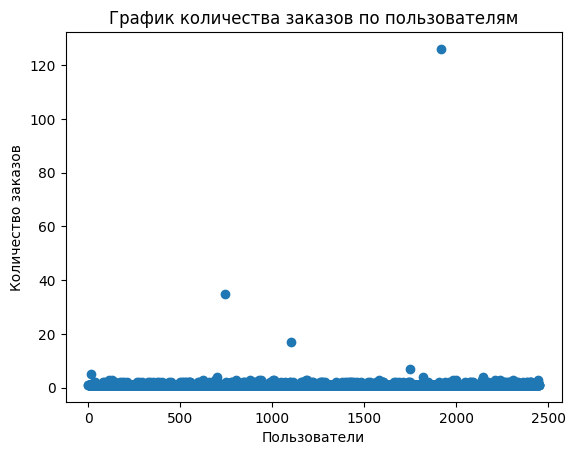

In [17]:
#построим дианрамму разброса по заказм
x_values = pd.Series(range(0,len(orders)))
plt.scatter(x_values, orders['order_id'])
plt.ylabel('Количество заказов')
plt.xlabel('Пользователи')
plt.title('График количества заказов по пользователям')
plt.show();

На графике видим три явных выброса: пользователи, количество заказов у которых 126, 35 и 17 заказов. особенно выделяется пользователь с 126 заказами. Количество неправдоподобно большое, поэтому признаем его выбросом и удаляем данного пользователя.

Отдельно вывела пользователя, у которого больше всего заказов

In [18]:
user_max = data.query('customer_id == ["c971fb21-d54c-4134-938f-16b62ee86d3b"]')
# строим scatter
fig = px.scatter(user_max,             # загружаем данные
                 x='date', # указываем столбец с данными для оси X
                 y="quantity",  # указываем столбец с данными для оси Y
                 color='name') # обозначаем категорию для разделения цветом
# оформляем график
fig.update_layout(title='Товары пользователя с наибольшим количеством заказов',
                   xaxis_title='Дата покупки',
                   yaxis_title='Количество товара')

fig.show() # выводим график

Заказ не похож на оптовый, разное количество товаров и они довольно разнообразны. Поэтому принимаем решение не удалять данного пользователя

#### 2.8.2. Поиск заказов с самым большим количеством товаров

In [19]:
#создадим датафрем orders_v2, в котором найдем заказы с самым большим количеством товаров
orders_v2 = data.groupby(['order_id'],as_index = False)['quantity'].sum().\
                 sort_values(by='quantity', ascending=False).\
                 reset_index(drop=True)
orders_v2.head(10)

,order_id,quantity
0,71743,1000
1,71668,334
2,68611,300
3,71478,300
4,69289,200
5,68815,170
6,72845,160
7,70841,150
8,68831,140
9,69156,101


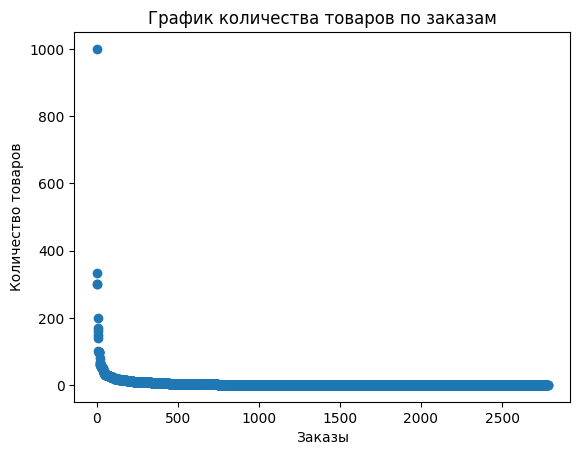

In [20]:
#построим дианрамму разброса по товарам
x_values = pd.Series(range(0,len(orders_v2)))
plt.scatter(x_values, orders_v2['quantity'])
plt.ylabel('Количество товаров')
plt.xlabel('Заказы')
plt.title('График количества товаров по заказам')
plt.show();

In [21]:
#выведем самый многочисленный заказ и посмотрим из чего он состоит
order_max = data.query('order_id == [71743]')
order_max

,date,customer_id,order_id,product,quantity,price,year_month,day_of_week,hour,revenue,name
3840,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,2019-06,1,15,675000.0,вантуз


In [22]:
#выведем другие большие заказы от 334 до 200 штук и посмтрим из чего они состоят
order_max_2 = data.query('order_id == [71668, 68611, 71478,69289]').sort_values(by='order_id')
order_max_2

,date,customer_id,order_id,product,quantity,price,year_month,day_of_week,hour,revenue,name
197,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Крепеж для пружины дверной, 1107055",150,19.0,2018-10,3,14,2850.0,крепеж для
198,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,Пружина дверная 240 мм оцинкованная (Д-19 мм) ...,150,38.0,2018-10,3,14,5700.0,пружина дверная
1014,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,29.0,2018-12,0,14,5800.0,ручка скоба
3390,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,Муляж ЯБЛОКО 9 см красное,300,51.0,2019-05,0,21,15300.0,муляж яблоко
3772,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,2019-06,1,7,49432.0,вешалки мягкие


На графике явно выделяется бльшой заказ на 1000 штук. Скорее всего это либо ошибка, либо оптовый заказ. Признаем его выбросом и удалим

In [23]:
data = data.query('order_id != [71743]') #удаляем заказ, признанный выбросом

Отдельно вывела самый многочисленный заказ. Он выглядит как оптовый - маловероятно что единовременно один пользователь закажет для личных нужд 1000 штук вантузов. Другие большие закзы от 334 до 200 штук товра в заказе не похожи на оптовые, поэтому они не были удалены.

#### 2.8.3. Поиск товаров с самыми высокими ценами

In [24]:
#поскольку имеет место разброс цен, для проверки используем медианную цену, а не среднюю

cost = data.groupby('name').agg({'quantity':'sum', 'price': 'median'}).sort_values(by='price', ascending=False)
cost.head(10)

,quantity,price
name,,
сушилка уличная,1,14917.0
стремянкаступенчатая алюминиевая,1,7724.0
автоматическая щеткадля,1,7229.0
урна уличная,2,7124.0
покрывало жаккардстеганое,1,6134.0
сушилка,3,5594.0
стремянкаступеней алюминиевая,1,5549.0
набор инструментов,1,5399.0
стремянка алюминиеваяступенчатая,1,4949.0


Видим, что цена на сушилку уличну довольно велика, но она может быть таковой, как и цены на другие товары.
Оставляем датафрем без изменений.

#### 2.8.4. Выведем данные по датафрему после изменений

In [25]:
print('Количество событий в датафреме:', data['order_id'].count())
print('Количество уникальных пользователей:', data['customer_id'].nunique())
print('Количество уникальных заказов:', data['order_id'].nunique())
print('Количество уникальных наименований товара:', data['name'].nunique())
print('Количество товаров в датафреме:', data['quantity'].sum())

Количество событий в датафреме: 4872
Количество уникальных пользователей: 2450
Количество уникальных заказов: 2783
Количество уникальных наименований товара: 1119
Количество товаров в датафреме: 12827


После удаления аномалий датафрем изменился на 3% (с 4873 до 4729). Это изменение менее 5%, поэтому оставляем получившийся датафрем для дальнейшего анализа.

### 2.9. Разделим товары на категории и создадим столбец category

In [26]:
#функция для разбивки товаров на категории:
#рассада, товары для хранения, декор, товары для уборки, прочие хозтовары, пасуда и цветы

def categorize_product(row):
    if ('рассада'in row['name'])or('мята'in row['name'])or('сорт'in row['name'])or(
        'капуста'in row['name'])or('арбуз'in row['name'])or('базилик'in row['name'])or(
        'дыня'in row['name'])or('руккола'in row['name'])or('земляника'in row['name'])or(
        'клубника'in row['name'])or('томат'in row['name'])or('огурец'in row['name'])or(
        'петрушка'in row['name'])or('баклажан'in row['name'])or('кабачок'in row['name'])or(
        'лук'in row['name'])or('морковь'in row['name'])or('патиссон'in row['name'])or(
        'трав'in row['name'])or('сельдерей'in row['name'])or('тыква'in row['name'])or(
        'укроп'in row['name'])or('виноград'in row['name']):
        return 'рассада'

    if ('сумка'in row['name'])or('контейнер'in row['name'])or('вешал'in row['name'])or(
        'корзин'in row['name'])or('тележка' in row['name'])or('чехол' in row['name'])or(
        'кофр' in row['name'])or('бак' in row['name'])or('короб' in row['name'])or(
        'мешок' in row['name'])or('ящик' in row['name'])or('этажерк' in row['name'])or(
        'комод' in row['name'])or('пакет' in row['name'])or(
        'стеллаж'in row['name'])or('сиденье'in row['name'])or('полк'in row['name']):
        return 'товары для хранения'

    if ('муляж'in row['name'])or('цветок'in row['name'])or('карниз'in row['name'])or(
        'штора'in row['name'])or('кашпо'in row['name'])or('дерево'in row['name'])or(
        'композиция'in row['name'])or('подушка'in row['name'])or(
        'салфет'in row['name'])or('халат' in row['name'])or('рамка' in row['name'])or(
        'скатерть'in row['name'])or('постель'in row['name'])or('одеял'in row['name'])or(
        'комплект'in row['name'])or('наматр'in row['name'])or('искусствен'in row['name'])or(
        'плед'in row['name'])or('плечики'in row['name'])or('покрывало'in row['name'])or(
        'простын'in row['name'])or('ткань'in row['name'])or('подставка'in row['name'])or(
        'ключниц'in row['name'])or('полотенц'in row['name'])or('скатерть'in row['name'])or(
        'ковер'in row['name']):
        return 'декор'

    if ('анти'in row['name'])or('аромат'in row['name'])or('бальзам'in row['name'])or(
        'ванна'in row['name'])or('вантуз'in row['name'])or('ведро'in row['name'])or(
        'веник'in row['name'])or('губка'in row['name'])or('держатель'in row['name'])or(
        'дозатор'in row['name'])or('емкость'in row['name'])or('ерш'in row['name'])or(
        'ковш'in row['name'])or('концентрат'in row['name'])or('корыто'in row['name'])or(
        'крем'in row['name'])or('лоток'in row['name'])or('маска'in row['name'])or(
        'мойка'in row['name'])or('мыл'in row['name'])or('ополаскив'in row['name'])or(
        'отбеливатель'in row['name'])or('отжим'in row['name'])or('паста'in row['name'])or(
        'пена'in row['name'])or('перчатк'in row['name'])or('порошок'in row['name'])or(
        'смен'in row['name'])or('совок'in row['name'])or('средство'in row['name'])or(
        'таз'in row['name'])or('тряпк'in row['name'])or('урна'in row['name'])or(
        'утюг'in row['name'])or('щвабра'in row['name'])or('щетка'in row['name']):
        return 'товары для уборки'

    if ('бензин'in row['name'])or('бидон'in row['name'])or('веревка'in row['name'])or(
        'весы'in row['name'])or('вкладыш'in row['name'])or('доска'in row['name'])or(
        'завертка'in row['name'])or('зажигалка'in row['name'])or('защит'in row['name'])or(
        'измерит'in row['name'])or('инструмент'in row['name'])or('кисточка'in row['name'])or(
        'ковр'in row['name'])or('кольца'in row['name'])or('кондиционер'in row['name'])or(
        'котел'in row['name'])or('кофе'in row['name'])or('крепеж'in row['name'])or(
        'крючок'in row['name'])or('лестница'in row['name'])or('набор'in row['name'])or(
        'насадка'in row['name'])or('основание'in row['name'])or('отделитель'in row['name'])or(
        'петля'in row['name'])or('подголовник'in row['name'])or('подкладка'in row['name'])or(
        'подрукав'in row['name'])or('покрытие'in row['name'])or('пресс'in row['name'])or(
        'прищеп'in row['name'])or('пробка'in row['name'])or('пружина'in row['name'])or(
        'решетка'in row['name'])or('ролик'in row['name'])or('рукав'in row['name'])or(
        'ручка'in row['name'])or('сварка'in row['name'])or('сверло'in row['name'])or(
        'светильник'in row['name'])or('сетка'in row['name'])or('склад'in row['name'])or(
        'скребок'in row['name'])or('стремян'in row['name'])or('стяжк'in row['name'])or(
        'сушилка'in row['name'])or('термометр'in row['name'])or('уголок'in row['name'])or(
        'фен'in row['name'])or('шар'in row['name'])or('шило'in row['name'])or('шнур'in row['name'])or(
        'шпагат'in row['name'])or('шпингалет'in row['name'])or('шприц'in row['name'])or(
        'штнг'in row['name']):
        return 'прочие хозтовары'

    if ('тарелка'in row['name'])or('сковород'in row['name'])or('банка'in row['name'])or(
        'нож'in row['name'])or('чайн'in row['name'])or('стакан'in row['name'])or(
        'кувшин'in row['name'])or('вилк'in row['name'])or('кастрюля'in row['name'])or(
        'салатник'in row['name'])or('лож'in row['name'])or('кружк'in row['name'])or(
        'блюд'in row['name'])or('миска'in row['name'])or('ваза'in row['name'])or(
        'венчик'in row['name'])or('хлебница'in row['name'])or('форма'in row['name'])or(
        'толкушка'in row['name'])or('термос'in row['name'])or('терка'in row['name'])or(
        'соков'in row['name'])or('скалка'in row['name'])or('сито'in row['name'])or(
        'рыбочистка'in row['name'])or('рассекатель'in row['name'])or('просеиватель'in row['name'])or(
        'миксер'in row['name'])or('мялка'in row['name'])or('крышка'in row['name'])or(
        'противень'in row['name'])or('сотейник'in row['name'])or('овоще'in row['name'])or(
        'штопор'in row['name']):
        return 'посуда'

    return 'цветы'

data['category'] = data.apply(categorize_product, axis=1)

In [27]:
#обнаружен неявный дубликат
data['name'] = data['name'].replace('искусственный цветок', 'цветок искусственный')

In [28]:
#выведем датафрем после всех изменений
data.head(10)

,date,customer_id,order_id,product,quantity,price,year_month,day_of_week,hour,revenue,name,category
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10,0,0,142.0,комнатное растение,цветы
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10,0,0,194.0,комнатное растение,цветы
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10,0,0,112.0,радермахера,цветы
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10,0,0,179.0,хризолидокарпус лутесценс,цветы
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10,0,0,112.0,циперус зумула,цветы
5,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0,2018-10,0,0,164.0,шеффлера лузеана,цветы
6,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0,2018-10,0,0,134.0,юкка нитчатая,цветы
7,2018-10-01 08:00:00,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0,2018-10,0,8,824.0,настенная сушилка,прочие хозтовары
8,2018-10-01 08:00:00,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С61...",1,269.0,2018-10,0,8,269.0,таз пластмассовый,товары для уборки
9,2018-10-01 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beig...,1,674.0,2018-10,0,9,674.0,чехол для,товары для хранения


Проверила обновленный датафрем на пропукси. По  результатам проверки пропуски отсутствуют. Т.е. всем товарам присвоена категория

In [29]:
print(data.isna().sum())

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
year_month     0
day_of_week    0
hour           0
revenue        0
name           0
category       0
dtype: int64


## 3. Анализ данных

### 3.1. Определим, какие категории товаров представлены в магазине

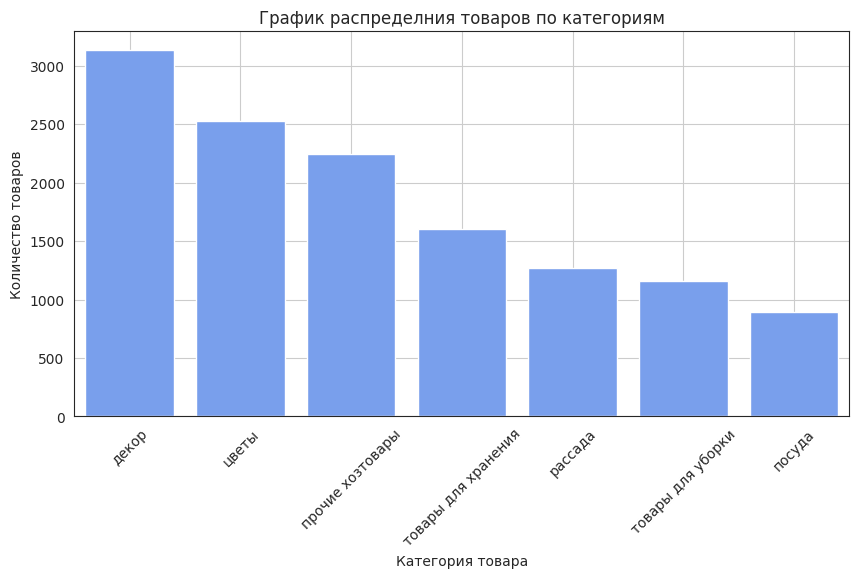

In [30]:
# группируем данные по категориям и количеству товаров
data_category = data.groupby(['category'],as_index = False)[['quantity']].sum().\
                     sort_values(by='quantity', ascending=False)
# используем стиль white из библиотеки seaborn
sns.set_style('white')
# назначаем размер графика
plt.figure(figsize=(10, 5))
# строим столбчатый график средствами seaborn
sns.barplot(x='category', y='quantity', data=data_category, color='#6698ff')
# формируем заголовок графика и подписи осей средствами matplotlib
plt.title('График распределния товаров по категориям')
plt.xlabel('Категория товара')
plt.ylabel('Количество товаров')
# поворачиваем подписи значений по оси X на 45 градусов
plt.xticks(rotation=45)
# добавляем сетку
plt.grid()
# отображаем график на экране
plt.show()

По графику видим, что больше всего товаров категории декор более 3000 штук, товаров в категории цветы около 2500 штук, в категории прочие хозтовары около 2100 штук. Около 1500 штук товаров в категори товары для хранения, около 1250 штук в категории рассада, чуть больше 1000 штук в категории товары для уборки. Товаров категории посуда около 900 штук, и это самая малочисленная категория.

Построим график с распределением медианной выручки от продажи товаров. Выбираем медиану, а не среднее, поскольку есть разброс цен и количества товаров. При применении средней это может исказить полученны результат.

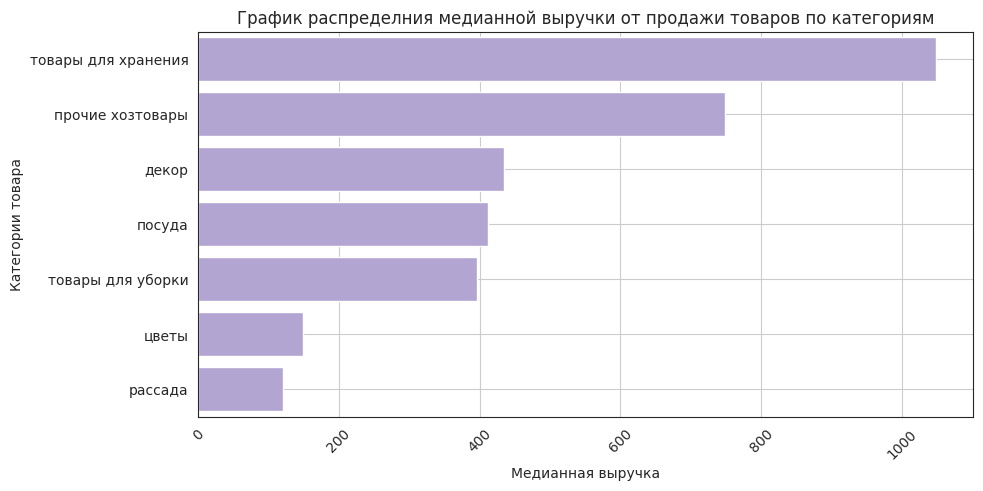

In [31]:
# группируем данные по категориям и выручке от продажи товаров той или иной категории
data_category_revenue = data.groupby(['category'],as_index = False)[['revenue']].median().\
                     sort_values(by='revenue', ascending=False)
# используем стиль white из библиотеки seaborn
sns.set_style('white')
# назначаем размер графика
plt.figure(figsize=(10, 5))
# строим столбчатый график средствами seaborn
sns.barplot(x='revenue', y='category', data=data_category_revenue, color='#af9dda')
# формируем заголовок графика и подписи осей средствами matplotlib
plt.title('График распределния медианной выручки от продажи товаров по категориям')
plt.xlabel('Медианная выручка')
plt.ylabel('Категории товара')
# поворачиваем подписи значений по оси X на 45 градусов
plt.xticks(rotation=45)
# добавляем сетку
plt.grid()
# отображаем график на экране
plt.show()

На графике видим, что самая высокая медианная выручка поступает от родажи товаров категории "товары для хранения" более 1000. На втором месте категория "прочие хозтовары" окло 700. Далее медианная выручка примерно на одном уровне у категорий "декор", "посуда" и "товары для уборки" - около 400. Самая низкая медианная выручка у товаров категорий "цветы" и "рассада" - менее 200.

### 3.2. Выявим товары основного и дополнительного ассортимента, рассмотрим и изобразим их соотношение, выявитм закономерности

#### 3.2.1. Определим процент от выручки, который приносит каждая позиция товара (проведение АВС теста)

In [32]:
# создадим отдельную переменную с общей выручкой по всем позициям товаров
total_revenue = data['revenue'].sum()

# создадим отдельную переменную с общим количеством товаров
total_count = data['quantity'].sum()

In [33]:
#определим процент от выручки, который приносит каждя позиция
abc_revenue = data.groupby('name').agg({'name': pd.Series.mode,
                                'quantity':'sum',
                                 'revenue':'sum'}).\
           sort_values(by='revenue', ascending=False).\
           reset_index(drop=True)

abc_revenue['share_revenue'] = round((abc_revenue['revenue']/total_revenue)*100, 2) #процент от общей выручки
abc_revenue.sort_values(by='share_revenue', ascending=False) #сортировка по проценту от общей выручки
abc_revenue['share_revenue_cum'] = abc_revenue['share_revenue'].cumsum() #процент от общей выручки нарастающим итогом

abc_revenue['abc_revenue_group'] = abc_revenue['share_revenue_cum'].apply(lambda abc:
              'A' if abc < 80 else('B' if  80 <= abc < 95 else 'C'))
#распределение товаров на группы А, В, С
abc_revenue

,name,quantity,revenue,share_revenue,share_revenue_cum,abc_revenue_group
0,сумка тележка,223,578091.0,16.67,16.67,A
1,сушилка для,298,281660.0,8.12,24.79,A
2,гладильная доска,122,214087.0,6.17,30.96,A
3,пеларгония зональная,488,77580.0,2.24,33.20,A
4,штора для,74,77027.0,2.22,35.42,A
...,...,...,...,...,...,...
1113,цинния оранжевый,1,10.0,0.00,99.84,C
1114,незабудка смесь,1,10.0,0.00,99.84,C
1115,петрушка итальянский,1,10.0,0.00,99.84,C
1116,цинния коралловая,1,10.0,0.00,99.84,C


In [34]:
#определим процент количества товаров от их общего количества
abc_quantity = data.groupby('name').agg({'name': pd.Series.mode,
                                'quantity':'sum',
                                 'revenue':'sum'}).\
           sort_values(by='quantity', ascending=False).\
           reset_index(drop=True)

abc_quantity['share_quantity'] = round((abc_quantity['quantity']/total_count)*100, 2) #процент от общего количества
abc_quantity.sort_values(by='share_quantity', ascending=False) #сортировка по проценту от общего количества
abc_quantity['share_quantity_cum'] = abc_quantity['share_quantity'].cumsum() #процент от общего количества нарастающим итогом

abc_quantity['abc_quantity_group'] = abc_quantity['share_quantity_cum'].apply(lambda abc:
              'A' if abc < 80 else('B' if  80 <= abc < 95 else 'C')) #распределение товаров на группы А, В, С
abc_quantity

,name,quantity,revenue,share_quantity,share_quantity_cum,abc_quantity_group
0,муляж яблоко,927,50333.0,7.23,7.23,A
1,цветок искусственный,721,22979.0,5.62,12.85,A
2,пеларгония зональная,488,77580.0,3.80,16.65,A
3,вешалки мягкие,341,50580.0,2.66,19.31,A
4,сушилка для,298,281660.0,2.32,21.63,A
...,...,...,...,...,...,...
1113,скатертьпрямоугольная бежевая,1,974.0,0.01,101.35,C
1114,скатертькуэнаполиэстер,1,764.0,0.01,101.36,C
1115,лаванда,1,112.0,0.01,101.37,C
1116,скатертьджулияполиэстерхлопок,1,2249.0,0.01,101.38,C


In [35]:
#объединим оба датафрема и оставим только столбцы name, abc_revenue_group и abc_quantity_group
abc_all = abc_revenue.merge(abc_quantity, on='name', how='left')
abc_all_group = abc_all[['name', 'abc_revenue_group', 'abc_quantity_group']]
abc_all_group

,name,abc_revenue_group,abc_quantity_group
0,сумка тележка,A,A
1,сушилка для,A,A
2,гладильная доска,A,A
3,пеларгония зональная,A,A
4,штора для,A,A
...,...,...,...
1113,цинния оранжевый,C,C
1114,незабудка смесь,C,C
1115,петрушка итальянский,C,C
1116,цинния коралловая,C,C


In [36]:
#сравним между собой группы и выделим АА, АВ, АС, ВА, ВВ, ВС, СА, СВ и СС
aa_name = abc_all_group[(abc_all_group['abc_revenue_group']=='A') & (abc_all_group['abc_quantity_group']=='A')]
aa_name_1 = aa_name['name']
print('АА:',aa_name['name'].count()) #товары приносят более 80% выручки и количество товаров более 80%

ab_name = abc_all_group[(abc_all_group['abc_revenue_group']=='A') & (abc_all_group['abc_quantity_group']=='B')]
ab_name_1 = ab_name['name']
print('АB:',ab_name['name'].count()) #товары приносят более 80% выпрчки и количество товаров около 15%

ac_name = abc_all_group[(abc_all_group['abc_revenue_group']=='A') & (abc_all_group['abc_quantity_group']=='C')]
ac_name_1 = ac_name['name']
print('АC:',ac_name['name'].count()) #товары приносят более 80% выручки и количество товаров около 5%

ba_name = abc_all_group[(abc_all_group['abc_revenue_group']=='B') & (abc_all_group['abc_quantity_group']=='A')]
ba_name_1 = ba_name['name']
print('BA:',ba_name['name'].count()) #товары приносят около 15% выручки и количество товаров более 80%

bb_name = abc_all_group[(abc_all_group['abc_revenue_group']=='B') & (abc_all_group['abc_quantity_group']=='B')]
bb_name_1 = bb_name['name']
print('BB:',bb_name['name'].count()) #товары приносят около 15% выручки и количество товаров около 15%

bc_name = abc_all_group[(abc_all_group['abc_revenue_group']=='B') & (abc_all_group['abc_quantity_group']=='C')]
bc_name_1 = bc_name['name']
print('BC:',bc_name['name'].count()) #товары приносят около 15% выручки и количество товаров около 5%

ca_name = abc_all_group[(abc_all_group['abc_revenue_group']=='C') & (abc_all_group['abc_quantity_group']=='A')]
ca_name_1 = ca_name['name']
print('CA:',ca_name['name'].count()) #товары приносят около 5% выручки и количество товаров более 80%

cb_name = abc_all_group[(abc_all_group['abc_revenue_group']=='C') & (abc_all_group['abc_quantity_group']=='B')]
cb_name_1 = cb_name['name']
print('CB:',cb_name['name'].count()) #товары приносят около 5% выручки и количество товаров около 15%

cc_name = abc_all_group[(abc_all_group['abc_revenue_group']=='C') & (abc_all_group['abc_quantity_group']=='C')]
cc_name_1 = cc_name['name']
print('CC:',cc_name['name'].count()) #товары приносят около 5% выручки и количество товаров около 5%

АА: 73
АB: 62
АC: 16
BA: 61
BB: 120
BC: 105
CA: 18
CB: 238
CC: 425


По итогам проведенного АВС анализа можно сделать следующие выводы. Были выделены списки товаров, выручка от продажи которых составляет основную часть от общей выручки и количество проданных товаров соствляет основную часть от всех проданных товаров. Это товары, которые попали в группы: АА, АВ, ВА, ВВ. Эти товары отнесем к основному ассортименту. К дополнительному ассортименту отнесем все оставшиеся товары, а именно те, которые попали в группы АС, ВС, CA, CB и СС. Особое внимание стоит обратить на товары категории СС, которых продается очень мало и выручка от их продажи минимальна.

#### 3.2.2. Определим основные товары и каких они категорий

In [37]:
#создадим датафрейм по товарам основного ассортимента
data_main = data.query('name in @aa_name_1 or name in @ab_name_1 or name in @ba_name_1 or \
                        name in @bb_name_1')
#создадим список товаров основного ассортимента
main_list = data_main['name'].unique()

In [38]:
#создадим датафрем main_products, в котором отразим к каким категориям относятся товары основного ассортимента.
main_products = data_main.groupby('category').agg({'category': pd.Series.mode,
                                           'quantity':'sum'}).\
                  sort_values(by='quantity', ascending=False).\
                  reset_index(drop=True)
main_products

,category,quantity
0,декор,2857
1,прочие хозтовары,2043
2,цветы,1957
3,товары для хранения,1549
4,товары для уборки,1054
5,рассада,727
6,посуда,702


In [39]:
print('Количество товаров основного ассортимента:', main_products['quantity'].sum())

Количество товаров основного ассортимента: 10889


In [40]:
# строим столбчатую диаграмму
fig = px.bar(main_products.sort_values(by='quantity', ascending=True), # загружаем данные и заново их сортируем
             x='quantity', # указываем столбец с данными для оси X
             y='category', # указываем столбец с данными для оси Y
             text='quantity', # добавляем аргумент, который отобразит текст с информацией
             color_discrete_sequence=["#2acaea"])

# оформляем график
fig.update_layout(title='Категории товаров основного ассортимента',
                   xaxis_title='Количество товаров',
                   yaxis_title='Категоря товара')
fig.show() # выводим график

Товаров основного ассортимента больше всего в категории декор (2857 штука), в категориях прочие хозтовары и цветы около 2000 штук (2043 и 1957 соответственно). Около 1500 штук товаров категории товары для хранения. В категории товары для уборки около 1064 штуки. Меньше всего товаров в категориях рассада и посуда (727 штука и 702 штук).

Товаров основного ассортимента больше всего в категории декор (3020 штук), в категориях цветы и прочие хозтовары около 2000 штук (2350 и 2044 соответственно). Около 1500 штук товаров категории товары для хранения. В категориях рассада и товары для уборки менее 1500 штук (1201 и 1093 соответственно). Меньше всего товаров в категории посуда (819 штук).   

#### 3.2.3. Изучим товары основного ассоримента категории декор (самой многочисленной)

In [41]:
#создадим датафрем с товарами основного ассоримента категории декор. Выделим топ-10 товаров этой категории
main_products_dekor = data_main.query('category == ["декор"]').\
                                    groupby('name').agg({'name': pd.Series.mode,
                                              'quantity':'sum'}).\
                         sort_values(by='quantity', ascending=False).\
                         reset_index(drop=True).head(10)

main_products_dekor

,name,quantity
0,муляж яблоко,927
1,цветок искусственный,721
2,плечики пластмассовые,166
3,муляж банан,109
4,муляж лимон,93
5,муляж красное,85
6,салфетка аметист,80
7,штора для,74
8,муляж оранжевое,59
9,муляж яблокооранжевыйполиуретан,52


In [42]:
# строим столбчатую диаграмму
fig = px.bar(main_products_dekor.sort_values(by='quantity', ascending=True), # загружаем данные и заново их сортируем
             x='quantity', # указываем столбец с данными для оси X
             y='name', # указываем столбец с данными для оси Y
             text='quantity', # добавляем аргумент, который отобразит текст с информацией
             color_discrete_sequence=["#b65fcf"])

# оформляем график
fig.update_layout(title='Наименование топ-10 товаров основного ассортимента категории "декор"',
                   xaxis_title='Количество товаров',
                   yaxis_title='Наименование товара')
fig.show() # выводим график

Больше всего товра "муляж яблоко" - 927 штук, затем по количеству идет искусственный цветок 721 штука. Далее 166 штук товара плечики пластмассовые. Такеж на графике видно, что в топ-10 товаров входят муляжи фруктов и цветов.

#### 3.2.4. Определим товары дополнительного ассортимента и каких они категорий

In [43]:
#создадим датафрейм по товарам дополнительного ассортимента
data_add = data.query('name in @ac_name_1 or name in @bc_name_1 or name in @cc_name_1 or\
                       name in @ca_name_1 or name in @bc_name_1')

#создадим список товаров доплнительного ассортимента
add_list = data_add['name'].unique()

In [44]:
#создадим датафрем add_products, в котором отразим к каким категориям относятся товары дополнительного ассортимента.
add_products = data_add.groupby('category').agg({'category': pd.Series.mode,
                                           'quantity':'sum'}).\
                  sort_values(by='quantity', ascending=False).\
                  reset_index(drop=True)
add_products

,category,quantity
0,цветы,232
1,рассада,199
2,декор,184
3,прочие хозтовары,138
4,посуда,98
5,товары для уборки,56
6,товары для хранения,42


In [45]:
print('Количество товаров дополнительного ассортимента:', add_products['quantity'].sum())

Количество товаров дополнительного ассортимента: 949


In [46]:
# строим столбчатую диаграмму
fig = px.bar(add_products.sort_values(by='quantity', ascending=True), # загружаем данные и заново их сортируем
             x='quantity', # указываем столбец с данными для оси X
             y='category', # указываем столбец с данными для оси Y
             text='quantity', # добавляем аргумент, который отобразит текст с информацией
             color_discrete_sequence=["#b65fcf"])

# оформляем график
fig.update_layout(title='Категории товаров дополнительного ассортимента',
                   xaxis_title='Количество товаров',
                   yaxis_title='Категория товара')
fig.show() # выводим график

Больше всего товаров дополнительного ассортимента категории цветы (232 штуки), затем категорий прочие рассада и декор (199 и 184 штуки соответственно). В категории прочие хозтовары 138 штук, в категории посуда 98 товаров дополнительного ассортимента. В категориях товары для уборки 56 штук, товары для хранения 42 штуки.

###  3.3. Сравним распределение выручки по категориям и количество проданных товаров.

In [47]:
fig1 = go.Figure(data=[go.Pie(labels=data['category'], values=data['quantity'])])
fig1.update_layout(title='Количество товаров по категориям', # указываем заголовок графика
                  width=500, # указываем размеры графика
                  height=400)
fig2 = go.Figure(data=[go.Pie(labels=data['category'], values=data['revenue'])])
fig2.update_layout(title='Выручка товаров по категориям', # указываем заголовок графика
                  width=500, # указываем размеры графика
                  height=400)
fig1.show()
fig2.show()

В магазине выделены 7 категорий товаров: декор, цветы, товары для хранения, рассада, посуда, товары для уборки и прочие ъозтовары.
На круговой диаграмме "Количество товаров по категориям" видим, что самая многочисленная категория - декор 24.5%. Вторая по численности категория - цветы 19.9%, далее прочие хозтовары - 16.9%, товары для хранения - 12.4%, рассада - 10.2%, товары для хуборки - 9.05% и самая малочисленная категория - посуда 7.02%.

По выручке картина несколько иная: больше всего выручка от продажи товаров в категории товары для хранения 31% и прочие хозтовары 26.8%. В связи с высокими уенами на данные товары, выручка от них больше, несмотря на их относительно не самое большре количество (3 и 4 место по количеству товаров). Далее декор 14.5% (занял третье место из-за большого количества товаров по сравнительно не высоким ценам - 1 место по количеству товаров), цветы 12.7% (также причина в сравнительно невысокой цене и большом количестве товаров - 2 место по количеству товаров). Товары следующих категорий приносят меньше всего выручки: товары для уборки 6.28%, посуда 4.74% и рассада 3.37%.  

### 3.4. Определим топ-10 самых популярных товаров, к каким категориям они относятся

In [48]:
#создадим датафрем с товарами, входящими в топ-10 по количеству
top10 = data.groupby('name').agg({'name': pd.Series.mode,
                                  'quantity':'sum'}).\
                  rename(columns={'quantity':'total_sum'}).\
                  sort_values(by='total_sum', ascending=False).\
                  reset_index(drop=True).head(10)
top10

,name,total_sum
0,муляж яблоко,927
1,цветок искусственный,721
2,пеларгония зональная,488
3,вешалки мягкие,341
4,сушилка для,298
5,пеларгония розебуднаяукорененный,288
6,крепеж для,270
7,щетка для,269
8,рассада зелени,247
9,сумка тележка,223


In [49]:
# строим столбчатую диаграмму
fig = px.bar(top10.sort_values(by='total_sum', ascending=True), # загружаем данные и заново их сортируем
             x='total_sum', # указываем столбец с данными для оси X
             y='name', # указываем столбец с данными для оси Y
             text='total_sum', # добавляем аргумент, который отобразит текст с информацией
             color_discrete_sequence=["#20b2aa"])

# оформляем график
fig.update_layout(title='Товары, входящие в топ-10 по количеству',
                   xaxis_title='Количество товаров',
                   yaxis_title='Наименование товара')
fig.show() # выводим график

Самым популярным товаром является муляж яблоко (927 штук), на втором месте цветок искусственный (721 штука), на третьем пеларгония зональная (цветок) 488 штук.


In [50]:
top10_list = top10['name'] #создадим список с наименованиями товаров, входящих в топ-10

In [51]:
#создадим датафрем с категориями товаров, входящих в топ-10
top10_v2 = data.query('name in @top10_list').\
                  groupby('category').agg({'category': pd.Series.mode,
                                           'quantity':'sum'}).\
                  rename(columns={'quantity':'total_sum'}).\
                  sort_values(by='total_sum', ascending=False).\
                  reset_index(drop=True)
top10_v2

,category,total_sum
0,декор,1648
1,цветы,776
2,прочие хозтовары,568
3,товары для хранения,564
4,товары для уборки,269
5,рассада,247


In [52]:
# строим столбчатую диаграмму
fig = px.bar(top10_v2.sort_values(by='total_sum', ascending=True), # загружаем данные и заново их сортируем
             x='total_sum', # указываем столбец с данными для оси X
             y='category', # указываем столбец с данными для оси Y
             text='total_sum', # добавляем аргумент, который отобразит текст с информацией
             color_discrete_sequence=["#e25c95"])

# оформляем график
fig.update_layout(title='Категории самых популярных товаров, входящих в топ-10',
                   xaxis_title='Количество товаров',
                   yaxis_title='Категории')
fig.show() # выводим график

Самые популярные товары относятся к категориям декор (1628 штук), цветы (776 штуки), прочие хозтовары (568 штук), товары для хранения (564 штука), товары для уборки (269 штук), рассада (247 штук)

### 3.5. Выясним, есть ли взаимосвязь между месяцем и количеством проджа

In [53]:
# готовим сводную таблицу
data_month = data.groupby(['year_month'], as_index=False)[['quantity']].\
                  sum().sort_values(by='year_month', ascending=True).\
                  reset_index(drop=True)

month = ['10 2018', '11 2018', '12 2018', '01 2019', '02 2019', '03 2019',
                                '04 2019', '05 2019','06 2019', '07 2019',
                                '08 2019', '09 2019', '10 2019']
data_month['month'] = month
#data_month = pd.to_datetime(data_month['year_month'], format='%m.%Y')

data_month


,year_month,quantity,month
0,2018-10,1559,10 2018
1,2018-11,1242,11 2018
2,2018-12,1027,12 2018
3,2019-01,615,01 2019
4,2019-02,982,02 2019
5,2019-03,1079,03 2019
6,2019-04,1460,04 2019
7,2019-05,1553,05 2019
8,2019-06,944,06 2019
9,2019-07,561,07 2019


In [54]:
# строим столбчатую диаграмму
fig = px.bar(data_month, # загружаем данные и заново их сортируем
             x='month', # указываем столбец с данными для оси X
             y='quantity', # указываем столбец с данными для оси Y
             text='month', # добавляем аргумент, который отобразит текст с информацией
             color='month')
fig.update_layout(yaxis={'categoryorder':'total descending'}) # сротировка графика
# оформляем график
fig.update_layout(title='Зависимость количества продаж от дня недели',
                   xaxis_title='День недели',
                   yaxis_title='Количество товаров')
fig.show() # выводим график

С октября 2018 по январь 2019 активность падает. Это скорее всего связано с ажиотажем перед новогодними праздниками, покупкой подраков. Затем в январе после праздников наступает спад активности (деньги потрачены, покупки совершены, покупательская способность снижена). Далее начинается рост, который достигает своего пика в мае 2019. Это можно обьяснить подготовкой к лету, дачному сезону, обновлению дома к лету и т.п. К августу 20219 снова начинается спад - летом многие уезжают в отпуска, не до покупок в магазине. Но к октябрю 2019 рост начинается снова.

### 3.6. Выясним, есть ли взаимосвязь между днем недели и количествои продаж

In [55]:
# готовим сводную таблицу
data_day = data.groupby(['day_of_week', 'category'], as_index=False
                       ).agg({'category': pd.Series.mode,
                              'day_of_week': pd.Series.mode,
                              'quantity':'sum'}).\
                sort_values(by='quantity', ascending=False).\
                reset_index(drop=True)

In [56]:
# строим столбчатую диаграмму
fig = px.bar(data_day.sort_values(by='quantity', ascending=True), # загружаем данные и заново их сортируем
             x='day_of_week', # указываем столбец с данными для оси X
             y='quantity', # указываем столбец с данными для оси Y
             text='category', # добавляем аргумент, который отобразит текст с информацией
             color='category')
fig.update_layout(yaxis={'categoryorder':'total descending'}) # сротировка графика
# оформляем график
fig.update_layout(title='Зависимость количества продаж от дня недели',
                   xaxis_title='День недели',
                   yaxis_title='Количество товаров')
fig.show() # выводим график

На графике видим, что больше всего товаров продается в понедельник. На втором месте по количеству продаж вторник и четверг.
Затем по количеству продаж идут среда и пятница. Меньше всего продаж в субботу.
В понедельник больше всего продано прочих хозтоваров и товаров категории декор и цветы.
Во вторник больше всего продано товаров для хранения и цветов.
В среду продано больше товаров категории декор.
В четверг больше всего продано товаров категории дкор, прочих хозтоваров и цветов.
В пятницу как т в среду больше всего продано категории декор.

### 3.7. Выясним, ести ли взаимосвязь между времененм (часом) и количествои продаж

In [57]:
# готовим сводную таблицу
data_hour = data.groupby(['hour', 'category'], as_index=False).agg({'category': pd.Series.mode,
                                                              'hour': pd.Series.mode,
                                                              'quantity':'sum'}).\
                sort_values(by='quantity', ascending=False).\
                reset_index(drop=True)

In [58]:
# строим столбчатую диаграмму
fig = px.bar(data_hour.sort_values(by='quantity', ascending=True), # загружаем данные и заново их сортируем
             x='hour', # указываем столбец с данными для оси X
             y='quantity', # указываем столбец с данными для оси Y
             text='category', # добавляем аргумент, который отобразит текст с информацией
             color='category')
fig.update_layout(yaxis={'categoryorder':'total descending'}) # сротировка графика
# оформляем график
fig.update_layout(title='Зависимость количества продаж от часа',
                   xaxis_title='Час',
                   yaxis_title='Количество товара')
fig.show() # выводим график

На графике видим, что лучше всего товары продаются в 14 и в 11 часов. С 00:00 до 6:00 продажи минимальны. В 7:00 замечен резкий подъем покупательской активности. Он стабильно растет каждый час и достигает своего пика в 11:00. Затер резкий спад в 12:00 и снова рост в 14:00 до максимального размере продаж. Затем идет спад активности до 18:00 и затем небольшой рост до 21:00. Далее активность снова снижается.

Можно предположить, что такая картина связана с режимом дня большинства потенциальных покупателей. Пики активности приходяться на обеденное время и вечернее, когда предположительно заканчивается работа или другие дела покупателей и появляется время листать товары в магазине.

## 4. Формулировка и проверка статистических гипотез

### 4.1. Средние чеки покупателей товаров основного и дополнительного ассортимента равны

```
H_0: Средний чек покупателей основного ассортимента равен среднему чеку покупателя дополнительного ассортимента`
H_a: Средний чек покупателей основного ассортимента не равен среднему чеку покупателя дополнительного ассортимента`
alpha = 0.05
```

In [59]:
#создадим датафрем со средними чеками покупателей основного ассортимента
main_avg = data_main.groupby('customer_id').agg({'customer_id': pd.Series.mode,
                                         'revenue':'mean'}).\
                     sort_values(by='revenue', ascending=False).\
                     reset_index(drop=True)

In [60]:
#создадим датафрем со средними чеками покупателей дополнительного ассортимента
add_avg = data_add.groupby('customer_id').agg({'customer_id': pd.Series.mode,
                                         'revenue':'mean'}).\
                     sort_values(by='revenue', ascending=False).\
                     reset_index(drop=True)

In [61]:
price_main = main_avg['revenue']
price_add = add_avg['revenue']

alpha = 0.05
results = st.ttest_ind(
    price_main,
    price_add, nan_policy='omit', equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")



# results = вызов метода для проверки гипотезы
# alpha = задайте значение уровня значимости
# вывод значения p-value на экран
# условный оператор с выводом строки с ответом

p-значение: 8.181096866810815e-07
Отвергаем нулевую гипотезу


Использовался метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам scipy.stats.ttest_ind (array1, array2, equal_var).

Значение p-value показывает: вероятность случайно получить такое или большее различие больше 100%
Т.е. нулевая гипотеза не верна - Средний чек покупателей основного ассортимента не равен среднему чеку покупателя дополнительного ассортимента. На мой взгляд также можно добавить, что средний чек основного ассортимента намного выше дополнительного.

### 4.2. Выручка проданных товаров основного и дополнительного ассортимента равны

```
H_0: Выручка проданных товаров основного ассортимента равна выручке проданных товаров дополнительного ассортимента`
H_a: Выручка проданных товаров основного ассортимента не равна выручке проданных товаров дополнительного ассортимента`
alpha = 0.05
```

In [62]:
revenue_main = data_main['revenue']
revenue_add = data_add['revenue']

alpha = 0.05
results = st.ttest_ind(
    revenue_main,
    revenue_add, nan_policy='omit', equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")



# results = вызов метода для проверки гипотезы
# alpha = задайте значение уровня значимости
# вывод значения p-value на экран
# условный оператор с выводом строки с ответом

p-значение: 5.965326591839802e-08
Отвергаем нулевую гипотезу


Использовался метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам scipy.stats.ttest_ind (array1, array2, equal_var).

Значение p-value показывает: вероятность случайно получить такое или большее различие больше 100%, но в половину меньше чем при проверке предыдущей гипотезы.
Таким образом, нулевая гипотеза не верна - Выручка проданных товаров основного ассортимента не равна выручке проданных товаров дополнительного ассортимента. Также как и в предыдущей гипотезе, выручка от продажи основного ассортимента во много раз выше, чем от дополнительного

## 5. Общий вывод и рекомендации по итогам проведенного анализа

Согласно проведенному исслеедованию, самая покупаемая категория товаров в интрнет-магазинее - это декор, цветы и прочие хозтовары. Меньше всего покупают товары категорий - рассада, товары для уборки и посуду.

К товарам основного ассортимента можно отнести в первую очередь товары категорий декор, прочие хозтовары и цветы. К товарам дополнительного ассортимента - категории цветы, рассада и декор.  

Самыми популярными товарами на сайте можно назвать муляжи яблок (и других фруктов), искусственные цветы, комнатные растения (например, пеларгония разных видов) и вешалки.

Делаем вывод, что на сайте много покупают товаров для декора и оформления. Можно расширить линейку данных товаров. Меньше всего покупается посуда, поэтому можно рекомендовать либо провести рекламную компанию, чтобы привлечь покупателя к этой категории, либо распродать остатки и вывести из ассортимента.

Также можно предложить добавить сопутствующие товары к категориям декор и цветы (например, горшки, земля для цветов и проч.)

Стоит обратить внимание также, что пиковая нагрузка по продажам приходится на октябрь и май, дни недели - понедельник и вторник, в 11, 14 и 21 час.

Меньше всего покупают в октябре и августе, день недели суббота, время с 0:00 до 6 утра, в 12 и 18 часов.
Чтобы привлечь в неходовое время покупателей, можно запустить скидочные акции, предложить ограниченные по времени скидки на категории товаров, добавить бесплатную доставку.

